In [2]:
print("Hello World")

Hello World


##### Step B.1 --> Load the dataset 

In [16]:
import pandas as pd 

# Load the raw data 
df = pd.read_csv("../data/raw/sales_data.csv")

df = df.rename(columns={
    "Store": "Store_ID",
    "Dept": "Item_ID",
    "Weekly_Sales": "Sales"
})

# Convert Date properly
df["Date"] = pd.to_datetime(df["Date"])

df.head()



,Store_ID,Item_ID,Date,Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [22]:
df.columns


Index(['Store_ID', 'Item_ID', 'Date', 'Sales', 'IsHoliday'], dtype='object')

##### Step B.2 --> Schema Check

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Store_ID   421570 non-null  int64         
 1   Item_ID    421570 non-null  int64         
 2   Date       421570 non-null  datetime64[ns]
 3   Sales      421570 non-null  float64       
 4   IsHoliday  421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


In [23]:
df['Date'] = pd.to_datetime(df['Date'])

##### Step B.3 --> Sort By Time (Critical)

In [24]:
df = df.sort_values('Date').reset_index(drop = True)
df[['Date']].head(), df[['Date']].tail()

# this step is to ensure that the date moves entirely forward in time 

(        Date
 0 2010-02-05
 1 2010-02-05
 2 2010-02-05
 3 2010-02-05
 4 2010-02-05,
              Date
 421565 2012-10-26
 421566 2012-10-26
 421567 2012-10-26
 421568 2012-10-26
 421569 2012-10-26)

##### Step B.4 --> Time Coverage Sanity Checks

In [25]:
print("Start Date : ", df['Date'].min())
print("End Date : ", df['Date'].max())
print("Total days : ", df['Date'].nunique())

Start Date :  2010-02-05 00:00:00
End Date :  2012-10-26 00:00:00
Total days :  143


In [26]:
df.groupby('Item_ID')['Date'].nunique().describe()


count     81.000000
mean     136.913580
std       24.557177
min       12.000000
25%      143.000000
50%      143.000000
75%      143.000000
max      143.000000
Name: Date, dtype: float64

##### Step B.5 --> Visualize the Sales Overtime (Global View)

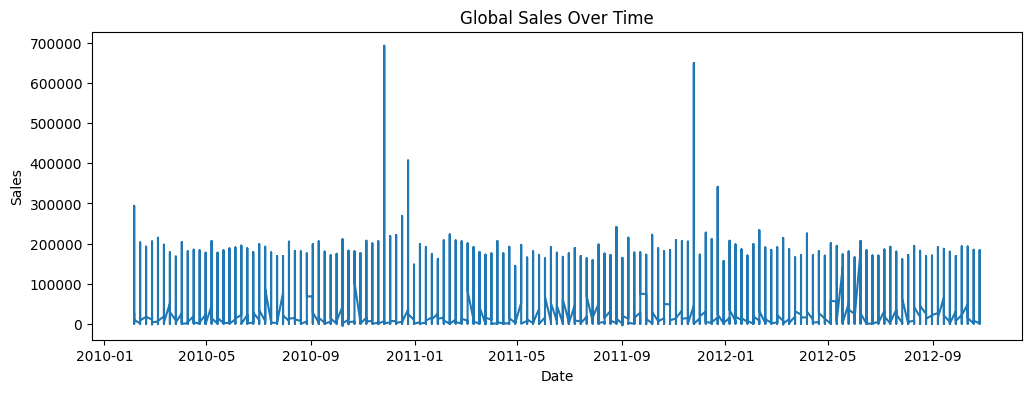

In [28]:
import matplotlib.pyplot as plt 
plt.figure(figsize = (12,4))
plt.plot(df['Date'], df['Sales'])
plt.title("Global Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


# there are spikes in tha data 


##### Step B.5 --> Multi - Entitiy Check 

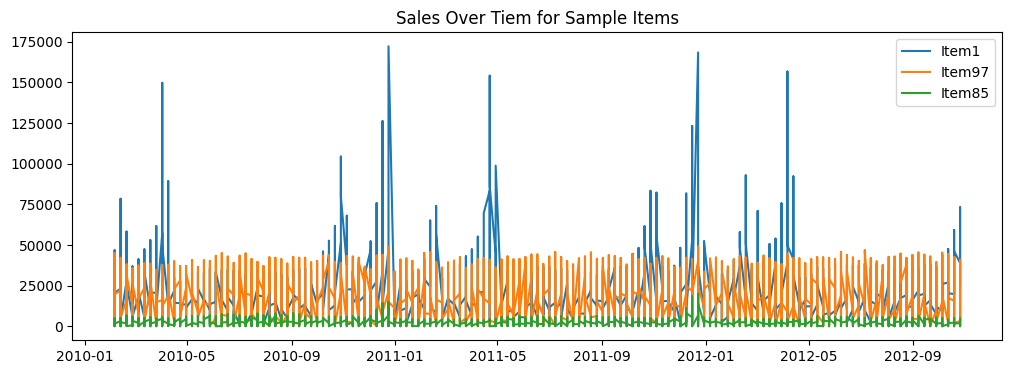

In [29]:
sample_items = df['Item_ID'].unique()[:3]
plt.figure(figsize = (12,4))
for item in sample_items:
    subset = df[df['Item_ID'] == item]
    plt.plot(subset['Date'], subset['Sales'], label = f"Item{item}")

plt.legend()
plt.title("Sales Over Tiem for Sample Items")
plt.show()

### ⚠️ Leakage Risks Identified
- Temporal leakage if data is randomly shuffled
- Target leakage via global item statistics
- Rolling features must be shifted to avoid future access


## Designing the Model

##### Step C.1 --> Creating the "Magical" Leaky Feature (Target Leakage)

In [57]:

df['Sales_Next_Week'] = (
    df.groupby(['Store_ID', 'Item_ID'])['Sales']
      .shift(-1)
)


##### Handle the NaNs

In [58]:
df_leaky = df.dropna(subset=['Sales_Next_Week'])


### ❌ Target Leakage Introduced
The feature `Global_Item_Avg` is calculated using the entire dataset,
including future sales values that would not be available at prediction time.


##### Step C.2 --> Prepare the Features

In [60]:
X = df_leaky[['Sales_Next_Week']]
y = df_leaky['Sales']

# Wanting the model to win easily 


##### Step C.3 --> The Illegal Split (Temporal Leakage)

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2, 
    shuffle = True, 
    random_state = 42
)


### ❌ Temporal Leakage Introduced
Random shuffling allows the model to train on future data
and predict past data — impossible in production.



##### Step C.4 --> Train the Model Using XG Boost 

In [62]:
import xgboost as xgb

model_leaky = xgb.XGBRegressor(random_state=42)
model_leaky.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

##### Step C.5 --> Evaluation - The Fake Victory 

In [63]:
from sklearn.metrics import r2_score 
y_pred = model_leaky.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f" Leaky Model R^2 Score : {r2:.4f}")

 Leaky Model R^2 Score : 0.9205


####  This Result Is a Lie

Although the R² score is extremely high, this model is invalid because:
1. It uses future information via 'Global Item Avg'
2. It violates time-order via random splitting
3. It cannot exist in a real production environment

This accuracy is not impressive — it is dangerous.


## Reality Check (The Crash)

##### Step D.1 --> Rebuild the Dataset in Correct Time Order

In [89]:
# Sort by time again (safely)
df_leaky = df_leaky.sort_values("Date").reset_index(drop = True)

##### Step D.2 --> Proper Time Based Split (No Shuffling)

In [90]:
split_index = int(len(df_leaky) * 0.8)

train_df = df_leaky.iloc[:split_index]
test_df = df_leaky.iloc[split_index:]

In [91]:
print(train_df['Date'].max())
print(test_df['Date'].min())


2012-04-06 00:00:00
2012-04-06 00:00:00


##### Step D.3 --> Prepare the Features

In [81]:
X_test_real = test_df[['Sales']]
y_test_real = test_df['Sales']

# this is like saying predict the sales for the week t using the available data before week t

In [92]:
# Rename column to match expected shape
X_test_real = X_test_real.rename(columns={'Sales': 'Sales_Next_Week'})


##### Step D.4 --> Evaluate the Same Model

In [93]:
from sklearn.metrics import r2_score

y_pred_real = model_leaky.predict(X_test_real)
r2_real = r2_score(y_test_real, y_pred_real)

print(f" Realistic Production R² Score: {r2_real:.4f}")


 Realistic Production R² Score: 0.9968


##### Step D.5 --> Visualization 

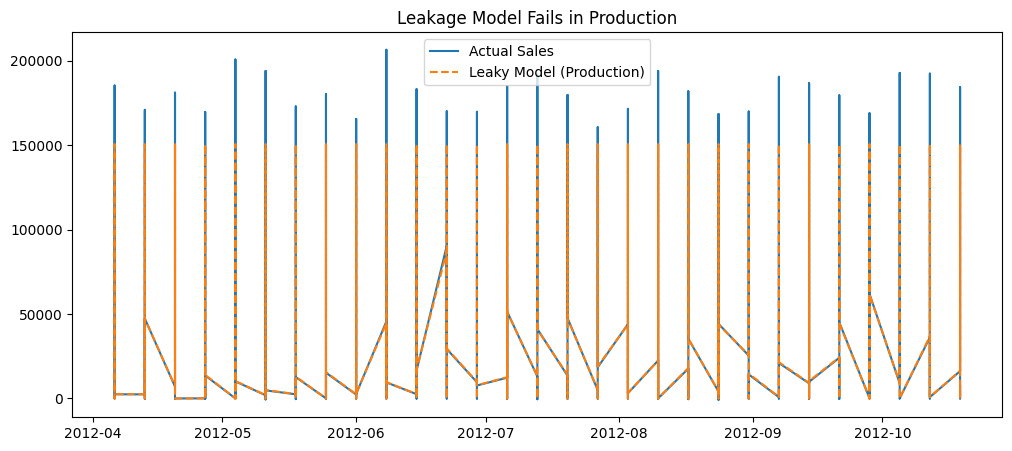

In [94]:
plt.figure(figsize=(12,5))
plt.plot(test_df['Date'], y_test_real, label="Actual Sales")
plt.plot(test_df['Date'], y_pred_real, label="Leaky Model (Production)", linestyle='--')
plt.title("Leakage Model Fails in Production")
plt.legend()
plt.show()


##### Reality Check: Why the Model Failed

When evaluated in a time-aware setting, the leaky model collapses.
This proves that the previous 0.92 R² score was an illusion caused by
future information leaking into the training process.

This model would fail immediately if deployed.
